# Fusion baseline Model (Ground)

## Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

2025-09-10 15:47:45.793066: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-10 15:47:45.798646: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757537265.804719  307570 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757537265.806727  307570 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-10 15:47:45.813852: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Config

In [2]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
DATA_DIR = Path("../data_processed")
OUT_DIR = Path("../models")
OUT_DIR.mkdir(parents=True, exist_ok=True)

TRAIN_PQ = DATA_DIR / "ground_train_h6.parquet"
VAL_PQ = DATA_DIR / "ground_val_h6.parquet"
TEST_PQ = DATA_DIR / "ground_test_h6.parquet"
TARGET = "y_k_h6"

FREQ     = "10min"
SEQ_LEN  = 12

### Hyperparameters

In [4]:
BATCH_SIZE = 100
EPOCHS = 50
PATIENCE = 15
LEARNING_RATE = 0.001

### Data loading and preprocessing

In [5]:
def load_and_preprocess_data():
    """Load and preprocess data for deep learning models"""
    train = pd.read_parquet(TRAIN_PQ)
    val = pd.read_parquet(VAL_PQ)
    test = pd.read_parquet(TEST_PQ)
    
    print(f"Data shapes - Train: {train.shape}, Val: {val.shape}, Test: {test.shape}")
    
    # Remove rows with NaN in target
    train = train.dropna(subset=[TARGET])
    val = val.dropna(subset=[TARGET])
    test = test.dropna(subset=[TARGET])
    
    # Separate features and target
    feat_cols = [c for c in train.columns if c != TARGET]
    
    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train[feat_cols])
    X_val = scaler.transform(val[feat_cols])
    X_test = scaler.transform(test[feat_cols])
    
    y_train = train[TARGET].values
    y_val = val[TARGET].values
    y_test = test[TARGET].values
    
    # Reshape for sequence models (samples, timesteps, features)
    # Using sequence length of 1 for tabular data, but can be extended for time series
    # X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    # X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    # X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # (samples, features, 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    return (X_train, y_train, X_val, y_val, X_test, y_test, feat_cols, scaler)

X_train, y_train, X_val, y_val, X_test, y_test, feat_cols, scaler = load_and_preprocess_data()

Data shapes - Train: (57789, 41), Val: (12384, 41), Test: (12384, 41)


## Models

### LSTM

In [6]:
def create_lstm_model(input_shape, units=64, dropout=0.2):
    """Create LSTM model"""
    model = models.Sequential([
        layers.LSTM(units, return_sequences=False, input_shape=input_shape,
                   dropout=dropout, recurrent_dropout=dropout),
        layers.Dense(32, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1)
    ])
    return model

### biLSTM

In [7]:
def create_bilstm_model(input_shape, units=64, dropout=0.2):
    """Create Bidirectional LSTM model"""
    model = models.Sequential([
        layers.Bidirectional(layers.LSTM(units, return_sequences=False, 
                                       dropout=dropout, recurrent_dropout=dropout),
                           input_shape=input_shape),
        layers.Dense(32, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1)
    ])
    return model

### CNN-LSTM

In [8]:
def create_cnn_lstm_model(input_shape, lstm_units=64, cnn_filters=32, dropout=0.2):
    """Create CNN-LSTM hybrid model"""
    model = models.Sequential([
        # Usar kernel_size=1 o ajustar padding para mantener dimensiones
        layers.Conv1D(cnn_filters, kernel_size=1, activation='relu', 
                     input_shape=input_shape, padding='same'),
        
        # Omitir MaxPooling1D o usar pool_size=1
        # layers.MaxPooling1D(pool_size=1),  # Alternativa: pooling que no reduce dimensión
        
        layers.LSTM(lstm_units, return_sequences=False, 
                   dropout=dropout, recurrent_dropout=dropout),
        layers.Dense(32, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(1)
    ])
    return model

### Transformer

In [9]:
def create_transformer_model(input_shape, num_heads=4, ff_dim=64, dropout=0.2):
    """Create Transformer-based model"""
    inputs = layers.Input(shape=input_shape)
    
    # Aplanar primero para evitar problemas de dimensión
    x = layers.Flatten()(inputs)
    x = layers.Dense(64, activation='relu')(x)  # Proyectar a dimensión fija
    x = layers.Reshape((64, 1))(x)  # Volver a dar forma de secuencia
    
    # Multi-head self-attention con dimensión fija
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, 
        key_dim=8,  # Dimensión fija
        dropout=dropout
    )(x, x)
    
    # Skip connection
    x = layers.Add()([x, attention_output])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Feed-forward network
    ffn = layers.Dense(ff_dim, activation="relu")(x)
    ffn = layers.Dense(input_shape[1])(ffn)
    ffn = layers.Dropout(dropout)(ffn)
    
    # Skip connection
    x = layers.Add()([x, ffn])
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # Global average pooling and output
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1)(x)
    
    return models.Model(inputs, outputs)

### Training & Evaluation

In [10]:
def train_model(model, model_name, X_train, y_train, X_val, y_val):
    """Train model with early stopping and learning rate reduction"""
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='mse',
        metrics=['mae']
    )
    
    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=PATIENCE,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=PATIENCE//2,
            verbose=1
        ),
        callbacks.ModelCheckpoint(
            filepath=OUT_DIR / f"{model_name}_best.h5",
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]
    
    history = model.fit(
        X_train, y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=callbacks_list,
        verbose=1
    )
    
    return history, model

In [11]:
def evaluate_model(model, X_test, y_test, model_name):
    """Evaluate model and return metrics"""
    y_pred = model.predict(X_test, verbose=0).flatten()
    
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred),
        'MBE': np.mean(y_pred - y_test)  # Mean Bias Error
    }
    
    # Save predictions
    results_df = pd.DataFrame({
        'actual': y_test,
        'predicted': y_pred
    })
    results_df.to_csv(OUT_DIR / f"{model_name}_predictions.csv", index=False)
    
    return metrics, y_pred

## Train and compare

In [12]:
models_dict = {
    'LSTM': create_lstm_model(X_train.shape[1:]),
    'BiLSTM': create_bilstm_model(X_train.shape[1:]),
    'CNN_LSTM': create_cnn_lstm_model(X_train.shape[1:]),
    'Transformer': create_transformer_model(X_train.shape[1:])
}

results = {}

for model_name, model in models_dict.items():
    print(f"\n{'='*50}")
    print(f"Training {model_name} model...")
    print(f"{'='*50}")
    
    # Train model
    history, trained_model = train_model(model, model_name, X_train, y_train, X_val, y_val)
    
    # Evaluate model
    metrics, y_pred = evaluate_model(trained_model, X_test, y_test, model_name)
    results[model_name] = metrics
    
    # Save model
    trained_model.save(OUT_DIR / f"{model_name}_model.keras")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title(f'{model_name} - MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{model_name}_training.png")
    plt.close()

I0000 00:00:1757537268.873026  307570 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22138 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/e.ladino/miniconda3/envs/e_ladino/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training LSTM model...
Epoch 1/50


/home/e.ladino/miniconda3/envs/e_ladino/lib/python3.12/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/e.ladino/miniconda3/envs/e_ladino/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 107572682752.0000 - mae: 46859.5430
Epoch 1: val_loss improved from None to 106869276672.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - loss: 108483936256.0000 - mae: 49407.9883 - val_loss: 106869276672.0000 - val_mae: 49381.1172 - learning_rate: 0.0010
Epoch 2/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 107494727680.0000 - mae: 47508.4688
Epoch 2: val_loss improved from 106869276672.00000 to 106725138432.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 108380684288.0000 - mae: 50238.5273 - val_loss: 106725138432.0000 - val_mae: 50583.9492 - learning_rate: 0.0010
Epoch 3/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 107343503360.0000 - mae: 48854.7539
Epoch 3: val_loss improved from 106725138432.00000 to 106521124864.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 108203474944.0000 - mae: 51720.8242 - val_loss: 106521124864.0000 - val_mae: 52378.1016 - learning_rate: 0.0010
Epoch 4/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 107141283840.0000 - mae: 50745.1484
Epoch 4: val_loss improved from 106521124864.00000 to 106279845888.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 107978883072.0000 - mae: 53723.8242 - val_loss: 106279845888.0000 - val_mae: 54641.9805 - learning_rate: 0.0010
Epoch 5/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 106904379392.0000 - mae: 53083.8594
Epoch 5: val_loss improved from 106279845888.00000 to 106023927808.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 107723849728.0000 - mae: 56141.6445 - val_loss: 106023927808.0000 - val_mae: 57243.9141 - learning_rate: 0.0010
Epoch 6/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 106663600128.0000 - mae: 55751.5039
Epoch 6: val_loss improved from 106023927808.00000 to 105773105152.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 107472658432.0000 - mae: 58843.2109 - val_loss: 105773105152.0000 - val_mae: 60039.4219 - learning_rate: 0.0010
Epoch 7/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 106429841408.0000 - mae: 58579.7891
Epoch 7: val_loss improved from 105773105152.00000 to 105536897024.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 107228364800.0000 - mae: 61695.6992 - val_loss: 105536897024.0000 - val_mae: 62965.9375 - learning_rate: 0.0010
Epoch 8/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 106211565568.0000 - mae: 61527.1797
Epoch 8: val_loss improved from 105536897024.00000 to 105324421120.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 107000766464.0000 - mae: 64627.7578 - val_loss: 105324421120.0000 - val_mae: 65929.4922 - learning_rate: 0.0010
Epoch 9/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 106052173824.0000 - mae: 64442.3203
Epoch 9: val_loss improved from 105324421120.00000 to 105141059584.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 106809671680.0000 - mae: 67536.3750 - val_loss: 105141059584.0000 - val_mae: 68842.2500 - learning_rate: 0.0010
Epoch 10/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 105871163392.0000 - mae: 67337.2266
Epoch 10: val_loss improved from 105141059584.00000 to 104989442048.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 106642563072.0000 - mae: 70383.6797 - val_loss: 104989442048.0000 - val_mae: 71619.7188 - learning_rate: 0.0010
Epoch 11/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 105715646464.0000 - mae: 70040.7422
Epoch 11: val_loss improved from 104989442048.00000 to 104865710080.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 106479157248.0000 - mae: 73066.4922 - val_loss: 104865710080.0000 - val_mae: 74263.5703 - learning_rate: 0.0010
Epoch 12/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 105650380800.0000 - mae: 72636.9453
Epoch 12: val_loss improved from 104865710080.00000 to 104772395008.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 106397392896.0000 - mae: 75547.0000 - val_loss: 104772395008.0000 - val_mae: 76615.8750 - learning_rate: 0.0010
Epoch 13/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 105567043584.0000 - mae: 74961.0000
Epoch 13: val_loss improved from 104772395008.00000 to 104701575168.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 106300399616.0000 - mae: 77817.1875 - val_loss: 104701575168.0000 - val_mae: 78742.5547 - learning_rate: 0.0010
Epoch 14/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 105547800576.0000 - mae: 76609.7109
Epoch 14: val_loss did not improve from 104701575168.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 106313940992.0000 - mae: 78158.6094 - val_loss: 104764579840.0000 - val_mae: 76832.8750 - learning_rate: 0.0010
Epoch 15/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 105586581504.0000 - mae: 74035.9766
Epoch 15: val_loss did not improve from 104701575168.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 106333208576.0000 - mae: 76749.9766 - val_loss: 104726134784.0000 - val_mae: 77960.0469 - learning_rate: 0.0010
Epoch 16/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 105538445312.0000 - mae: 76218.2188
Epoch 16: val_loss improved from 104701575168.00000 to 104669806592.00000, saving model to ../model

578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 106269614080.0000 - mae: 78987.8516 - val_loss: 104669806592.0000 - val_mae: 79843.8750 - learning_rate: 0.0010
Epoch 17/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 105495265280.0000 - mae: 78022.1953
Epoch 17: val_loss improved from 104669806592.00000 to 104629018624.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 106229710848.0000 - mae: 80738.6172 - val_loss: 104629018624.0000 - val_mae: 81476.5234 - learning_rate: 0.0010
Epoch 18/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 105460006912.0000 - mae: 79604.1406
Epoch 18: val_loss improved from 104629018624.00000 to 104599945216.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 106192330752.0000 - mae: 82233.1953 - val_loss: 104599945216.0000 - val_mae: 82876.8672 - learning_rate: 0.0010
Epoch 19/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 105468903424.0000 - mae: 80963.9531
Epoch 19: val_loss improved from 104599945216.00000 to 104579874816.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 106177011712.0000 - mae: 83512.5234 - val_loss: 104579874816.0000 - val_mae: 84042.3828 - learning_rate: 0.0010
Epoch 20/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 105442402304.0000 - mae: 82034.4844
Epoch 20: val_loss improved from 104579874816.00000 to 104566202368.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 106168123392.0000 - mae: 84575.9688 - val_loss: 104566202368.0000 - val_mae: 85002.9062 - learning_rate: 0.0010
Epoch 21/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 105414000640.0000 - mae: 82914.6484
Epoch 21: val_loss improved from 104566202368.00000 to 104556388352.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 106137845760.0000 - mae: 85421.8516 - val_loss: 104556388352.0000 - val_mae: 85830.6562 - learning_rate: 0.0010
Epoch 22/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 105453846528.0000 - mae: 81342.3125
Epoch 22: val_loss did not improve from 104556388352.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 106150264832.0000 - mae: 77702.6719 - val_loss: 105299771392.0000 - val_mae: 59296.0625 - learning_rate: 0.0010
Epoch 23/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 105380397056.0000 - mae: 65805.2969
Epoch 23: val_loss improved from 104556388352.00000 to 103935344640.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 105861980160.0000 - mae: 73584.0625 - val_loss: 103935344640.0000 - val_mae: 77463.0234 - learning_rate: 0.0010
Epoch 24/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104950046720.0000 - mae: 76128.4766
Epoch 24: val_loss improved from 103935344640.00000 to 103865737216.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 105601286144.0000 - mae: 78572.0000 - val_loss: 103865737216.0000 - val_mae: 77335.5078 - learning_rate: 0.0010
Epoch 25/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104730361856.0000 - mae: 75251.9766
Epoch 25: val_loss improved from 103865737216.00000 to 103811997696.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 105464741888.0000 - mae: 77403.7734 - val_loss: 103811997696.0000 - val_mae: 77632.5000 - learning_rate: 0.0010
Epoch 26/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 105782935552.0000 - mae: 62754.7109
Epoch 26: val_loss did not improve from 103811997696.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 106670669824.0000 - mae: 62019.1602 - val_loss: 104539103232.0000 - val_mae: 67691.7500 - learning_rate: 0.0010
Epoch 27/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 105620267008.0000 - mae: 60727.8789
Epoch 27: val_loss did not improve from 103811997696.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 106289422336.0000 - mae: 64220.4648 - val_loss: 104193048576.0000 - val_mae: 73893.1641 - learning_rate: 0.0010
Epoch 28/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104992956416.0000 - mae: 73567.1797
Epoch 28: val_loss improved from 103811997696.00000 to 103772561408.00000, saving model to ../model

578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 105551192064.0000 - mae: 78162.1328 - val_loss: 103772561408.0000 - val_mae: 86055.5547 - learning_rate: 0.0010
Epoch 29/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104909250560.0000 - mae: 84378.7109
Epoch 29: val_loss improved from 103772561408.00000 to 103704068096.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 105514590208.0000 - mae: 86439.0156 - val_loss: 103704068096.0000 - val_mae: 83787.1016 - learning_rate: 0.0010
Epoch 30/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104769159168.0000 - mae: 82506.2891
Epoch 30: val_loss did not improve from 103704068096.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 105404030976.0000 - mae: 84719.9297 - val_loss: 103724236800.0000 - val_mae: 84382.6875 - learning_rate: 0.0010
Epoch 31/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104811978752.0000 - mae: 82157.2422
Epoch 31: val_loss did not improve from 103704068096.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 105437077504.0000 - mae: 84436.7812 - val_loss: 103738130432.0000 - val_mae: 83211.0469 - learning_rate: 0.0010
Epoch 32/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104767651840.0000 - mae: 82025.4766
Epoch 32: val_loss improved from 103704068096.00000 to 103701446656.00000, saving model to ../model

578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 105403121664.0000 - mae: 84457.1719 - val_loss: 103701446656.0000 - val_mae: 84565.8203 - learning_rate: 0.0010
Epoch 33/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104756813824.0000 - mae: 82130.3047
Epoch 33: val_loss did not improve from 103701446656.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 105381666816.0000 - mae: 82840.3906 - val_loss: 103708819456.0000 - val_mae: 83002.0078 - learning_rate: 0.0010
Epoch 34/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104742772736.0000 - mae: 77893.8125
Epoch 34: val_loss did not improve from 103701446656.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 105419702272.0000 - mae: 82101.3281 - val_loss: 103716020224.0000 - val_mae: 85190.6328 - learning_rate: 0.0010
Epoch 35/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104848867328.0000 - mae: 83282.0000
Epoch 35: val_loss did not improve from 103701446656.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/st

578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 105356763136.0000 - mae: 82744.6719 - val_loss: 103691075584.0000 - val_mae: 82977.7109 - learning_rate: 0.0010
Epoch 37/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104655527936.0000 - mae: 78903.2891
Epoch 37: val_loss did not improve from 103691075584.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 105391095808.0000 - mae: 80285.3359 - val_loss: 103937908736.0000 - val_mae: 76416.2031 - learning_rate: 0.0010
Epoch 38/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104791367680.0000 - mae: 76273.9453
Epoch 38: val_loss improved from 103691075584.00000 to 103672635392.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 105376407552.0000 - mae: 80435.9922 - val_loss: 103672635392.0000 - val_mae: 86547.2578 - learning_rate: 0.0010
Epoch 39/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104825585664.0000 - mae: 85931.8203
Epoch 39: val_loss did not improve from 103672635392.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 105519153152.0000 - mae: 89189.4453 - val_loss: 103849164800.0000 - val_mae: 89888.0938 - learning_rate: 0.0010
Epoch 40/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104878915584.0000 - mae: 86163.8984
Epoch 40: val_loss did not improve from 103672635392.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 105490251776.0000 - mae: 87091.9844 - val_loss: 103710334976.0000 - val_mae: 88515.7344 - learning_rate: 0.0010
Epoch 41/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104722333696.0000 - mae: 84217.3594
Epoch 41: val_loss did not improve from 103672635392.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/st

578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 105267003392.0000 - mae: 82570.5000 - val_loss: 103644127232.0000 - val_mae: 87120.3125 - learning_rate: 0.0010
Epoch 46/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104567472128.0000 - mae: 81680.2578
Epoch 46: val_loss did not improve from 103644127232.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 105259597824.0000 - mae: 81968.7109 - val_loss: 103672176640.0000 - val_mae: 82046.3906 - learning_rate: 0.0010
Epoch 47/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104628551680.0000 - mae: 76976.4688
Epoch 47: val_loss improved from 103644127232.00000 to 103575576576.00000, saving model to ../models/LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 105227804672.0000 - mae: 80244.9531 - val_loss: 103575576576.0000 - val_mae: 87960.7891 - learning_rate: 0.0010
Epoch 48/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104528437248.0000 - mae: 81047.8359
Epoch 48: val_loss did not improve from 103575576576.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 105190662144.0000 - mae: 82342.7969 - val_loss: 103577878528.0000 - val_mae: 84731.0391 - learning_rate: 0.0010
Epoch 49/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104627290112.0000 - mae: 78755.5234
Epoch 49: val_loss did not improve from 103575576576.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - loss: 105226821632.0000 - mae: 80064.6328 - val_loss: 103635918848.0000 - val_mae: 82435.1328 - learning_rate: 0.0010
Epoch 50/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 104521736192.0000 - mae: 78458.2109
Epoch 50: val_loss did not improve from 103575576576.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/st

578/578 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - loss: 108455002112.0000 - mae: 49635.4141 - val_loss: 106792943616.0000 - val_mae: 50012.0977 - learning_rate: 0.0010
Epoch 2/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 107389599744.0000 - mae: 48439.5742
Epoch 2: val_loss improved from 106792943616.00000 to 106487234560.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 108227198976.0000 - mae: 51515.7344 - val_loss: 106487234560.0000 - val_mae: 52676.9141 - learning_rate: 0.0010
Epoch 3/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 107065376768.0000 - mae: 51432.9570
Epoch 3: val_loss improved from 106487234560.00000 to 106074382336.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - loss: 107858714624.0000 - mae: 54838.3281 - val_loss: 106074382336.0000 - val_mae: 56712.5977 - learning_rate: 0.0010
Epoch 4/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 106664787968.0000 - mae: 55610.0938
Epoch 4: val_loss improved from 106074382336.00000 to 105691602944.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 107444649984.0000 - mae: 59064.2734 - val_loss: 105691602944.0000 - val_mae: 61011.7773 - learning_rate: 0.0010
Epoch 5/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 106329874432.0000 - mae: 59952.4414
Epoch 5: val_loss improved from 105691602944.00000 to 105345572864.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 107089592320.0000 - mae: 63451.2227 - val_loss: 105345572864.0000 - val_mae: 65617.7969 - learning_rate: 0.0010
Epoch 6/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 106021838848.0000 - mae: 64606.0664
Epoch 6: val_loss improved from 105345572864.00000 to 105055027200.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 106763550720.0000 - mae: 68157.5469 - val_loss: 105055027200.0000 - val_mae: 70367.5859 - learning_rate: 0.0010
Epoch 7/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 105809076224.0000 - mae: 68916.7031
Epoch 7: val_loss improved from 105055027200.00000 to 104881889280.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 106550452224.0000 - mae: 72142.6797 - val_loss: 104881889280.0000 - val_mae: 73717.3125 - learning_rate: 0.0010
Epoch 8/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 105674522624.0000 - mae: 71807.9453
Epoch 8: val_loss improved from 104881889280.00000 to 104754683904.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 106392748032.0000 - mae: 75227.3984 - val_loss: 104754683904.0000 - val_mae: 77109.5234 - learning_rate: 0.0010
Epoch 9/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 105517342720.0000 - mae: 75654.8750
Epoch 9: val_loss improved from 104754683904.00000 to 104653357056.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 106254475264.0000 - mae: 78829.3359 - val_loss: 104653357056.0000 - val_mae: 80371.4453 - learning_rate: 0.0010
Epoch 10/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 105479831552.0000 - mae: 78571.2109
Epoch 10: val_loss improved from 104653357056.00000 to 104617992192.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 106190258176.0000 - mae: 81107.6797 - val_loss: 104617992192.0000 - val_mae: 81779.1406 - learning_rate: 0.0010
Epoch 11/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 105422741504.0000 - mae: 79941.1250
Epoch 11: val_loss improved from 104617992192.00000 to 104576344064.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 106149380096.0000 - mae: 82566.8672 - val_loss: 104576344064.0000 - val_mae: 83277.4766 - learning_rate: 0.0010
Epoch 12/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 105417334784.0000 - mae: 81317.4375
Epoch 12: val_loss improved from 104576344064.00000 to 104539807744.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 106121216000.0000 - mae: 84000.6094 - val_loss: 104539807744.0000 - val_mae: 84916.5078 - learning_rate: 0.0010
Epoch 13/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 105558302720.0000 - mae: 77024.9297
Epoch 13: val_loss improved from 104539807744.00000 to 104512659456.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 106254761984.0000 - mae: 79032.1953 - val_loss: 104512659456.0000 - val_mae: 85435.0938 - learning_rate: 0.0010
Epoch 14/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 105317523456.0000 - mae: 81062.2891
Epoch 14: val_loss improved from 104512659456.00000 to 104445444096.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 106007928832.0000 - mae: 84617.6719 - val_loss: 104445444096.0000 - val_mae: 87978.8359 - learning_rate: 0.0010
Epoch 15/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 105326313472.0000 - mae: 84197.9922
Epoch 15: val_loss improved from 104445444096.00000 to 104410185728.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - loss: 106048839680.0000 - mae: 86321.2422 - val_loss: 104410185728.0000 - val_mae: 87926.9141 - learning_rate: 0.0010
Epoch 16/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 105328574464.0000 - mae: 83347.4062
Epoch 16: val_loss improved from 104410185728.00000 to 104118599680.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 106055852032.0000 - mae: 81619.0469 - val_loss: 104118599680.0000 - val_mae: 74747.3438 - learning_rate: 0.0010
Epoch 17/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 105067913216.0000 - mae: 72548.8281
Epoch 17: val_loss improved from 104118599680.00000 to 103908040704.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - loss: 105795788800.0000 - mae: 74783.1016 - val_loss: 103908040704.0000 - val_mae: 79755.9219 - learning_rate: 0.0010
Epoch 18/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 105063776256.0000 - mae: 72438.3828
Epoch 18: val_loss did not improve from 103908040704.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 105829949440.0000 - mae: 75228.3750 - val_loss: 104451293184.0000 - val_mae: 76336.8047 - learning_rate: 0.0010
Epoch 19/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 105266380800.0000 - mae: 73963.4219
Epoch 19: val_loss did not improve from 103908040704.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 105991143424.0000 - mae: 78034.9688 - val_loss: 104375934976.0000 - val_mae: 83038.6094 - learning_rate: 0.0010
Epoch 20/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 105410666496.0000 - mae: 75538.6797
Epoch 20: val_loss did not improve from 103908040704.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/st

578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - loss: 105624117248.0000 - mae: 77723.7969 - val_loss: 103793713152.0000 - val_mae: 78295.9453 - learning_rate: 0.0010
Epoch 23/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 104774533120.0000 - mae: 75037.1406
Epoch 23: val_loss improved from 103793713152.00000 to 103657013248.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 105411297280.0000 - mae: 78584.2734 - val_loss: 103657013248.0000 - val_mae: 81517.0547 - learning_rate: 0.0010
Epoch 24/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 104588918784.0000 - mae: 78124.6797
Epoch 24: val_loss did not improve from 103657013248.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 105208414208.0000 - mae: 81754.9453 - val_loss: 103894990848.0000 - val_mae: 89641.2500 - learning_rate: 0.0010
Epoch 25/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 104569643008.0000 - mae: 82306.9766
Epoch 25: val_loss did not improve from 103657013248.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 105179029504.0000 - mae: 85090.2266 - val_loss: 103829733376.0000 - val_mae: 93444.7734 - learning_rate: 0.0010
Epoch 26/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 104555839488.0000 - mae: 83269.7891
Epoch 26: val_loss did not improve from 103657013248.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/st

578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 105055928320.0000 - mae: 82777.8750 - val_loss: 103556685824.0000 - val_mae: 87610.9141 - learning_rate: 0.0010
Epoch 29/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 104323571712.0000 - mae: 79138.4531
Epoch 29: val_loss improved from 103556685824.00000 to 103471890432.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 104946212864.0000 - mae: 81095.0547 - val_loss: 103471890432.0000 - val_mae: 88570.4844 - learning_rate: 0.0010
Epoch 30/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 104193097728.0000 - mae: 77216.8359
Epoch 30: val_loss did not improve from 103471890432.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 104828469248.0000 - mae: 79404.3672 - val_loss: 103524818944.0000 - val_mae: 88763.5859 - learning_rate: 0.0010
Epoch 31/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 104183144448.0000 - mae: 79440.1406
Epoch 31: val_loss did not improve from 103471890432.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 104815632384.0000 - mae: 83201.6328 - val_loss: 103598882816.0000 - val_mae: 94165.1875 - learning_rate: 0.0010
Epoch 32/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 104157495296.0000 - mae: 82008.6172
Epoch 32: val_loss did not improve from 103471890432.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/st

578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - loss: 104863817728.0000 - mae: 78934.7891 - val_loss: 103433560064.0000 - val_mae: 83930.2500 - learning_rate: 0.0010
Epoch 35/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 104196521984.0000 - mae: 76990.3516
Epoch 35: val_loss did not improve from 103433560064.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 104799166464.0000 - mae: 80430.5703 - val_loss: 103660781568.0000 - val_mae: 89403.1953 - learning_rate: 0.0010
Epoch 36/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 104072519680.0000 - mae: 78594.7031
Epoch 36: val_loss did not improve from 103433560064.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 104734253056.0000 - mae: 81016.0312 - val_loss: 103508508672.0000 - val_mae: 91450.9375 - learning_rate: 0.0010
Epoch 37/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 104157978624.0000 - mae: 79406.2812
Epoch 37: val_loss did not improve from 103433560064.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/st

578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 104358731776.0000 - mae: 84567.2578 - val_loss: 103298957312.0000 - val_mae: 90397.7266 - learning_rate: 5.0000e-04
Epoch 43/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 103884349440.0000 - mae: 81753.2734
Epoch 43: val_loss improved from 103298957312.00000 to 103276650496.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 104460664832.0000 - mae: 84669.3203 - val_loss: 103276650496.0000 - val_mae: 90242.8906 - learning_rate: 5.0000e-04
Epoch 44/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 103902330880.0000 - mae: 80642.6562
Epoch 44: val_loss improved from 103276650496.00000 to 103239663616.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 104468799488.0000 - mae: 83331.4453 - val_loss: 103239663616.0000 - val_mae: 89995.4766 - learning_rate: 5.0000e-04
Epoch 45/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 103931207680.0000 - mae: 81227.5078
Epoch 45: val_loss improved from 103239663616.00000 to 103213473792.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 104416583680.0000 - mae: 84303.9844 - val_loss: 103213473792.0000 - val_mae: 90639.2422 - learning_rate: 5.0000e-04
Epoch 46/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 103693729792.0000 - mae: 81692.6562
Epoch 46: val_loss did not improve from 103213473792.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 104284413952.0000 - mae: 84130.1406 - val_loss: 103258038272.0000 - val_mae: 89568.6094 - learning_rate: 5.0000e-04
Epoch 47/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 103903158272.0000 - mae: 81971.7656
Epoch 47: val_loss did not improve from 103213473792.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 104358289408.0000 - mae: 84005.3516 - val_loss: 103238393856.0000 - val_mae: 87202.4688 - learning_rate: 5.0000e-04
Epoch 48/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 103749025792.0000 - mae: 80431.7422
Epoch 48: val_loss did not improve from 103213473792.00000
578/578 ━━━━━━━━━━━━━━━━━━━━

578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - loss: 104320581632.0000 - mae: 84990.2344 - val_loss: 103206387712.0000 - val_mae: 89863.7422 - learning_rate: 5.0000e-04
Epoch 50/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 103607484416.0000 - mae: 81274.4844
Epoch 50: val_loss improved from 103206387712.00000 to 103031578624.00000, saving model to ../models/BiLSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - loss: 104129830912.0000 - mae: 83947.2266 - val_loss: 103031578624.0000 - val_mae: 89324.8203 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 50.

Training CNN_LSTM model...
Epoch 1/50
  4/578 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 101286428672.0000 - mae: 50569.5938

I0000 00:00:1757538783.429153  307699 cuda_dnn.cc:529] Loaded cuDNN version 90101


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 107575164928.0000 - mae: 46875.7852
Epoch 1: val_loss improved from None to 106870038528.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - loss: 108483272704.0000 - mae: 49414.9336 - val_loss: 106870038528.0000 - val_mae: 49374.8125 - learning_rate: 0.0010
Epoch 2/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 107500781568.0000 - mae: 47500.5703
Epoch 2: val_loss improved from 106870038528.00000 to 106731347968.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 108384223232.0000 - mae: 50208.0664 - val_loss: 106731347968.0000 - val_mae: 50530.5078 - learning_rate: 0.0010
Epoch 3/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 107351334912.0000 - mae: 48775.5352
Epoch 3: val_loss improved from 106731347968.00000 to 106534862848.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 108213993472.0000 - mae: 51633.4531 - val_loss: 106534862848.0000 - val_mae: 52253.9805 - learning_rate: 0.0010
Epoch 4/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 107155808256.0000 - mae: 50607.6523
Epoch 4: val_loss improved from 106534862848.00000 to 106304159744.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 107997421568.0000 - mae: 53555.5586 - val_loss: 106304159744.0000 - val_mae: 54406.2031 - learning_rate: 0.0010
Epoch 5/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 106932240384.0000 - mae: 52838.2617
Epoch 5: val_loss improved from 106304159744.00000 to 106060316672.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 107761426432.0000 - mae: 55851.8867 - val_loss: 106060316672.0000 - val_mae: 56859.6914 - learning_rate: 0.0010
Epoch 6/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 106743873536.0000 - mae: 54926.0117
Epoch 6: val_loss improved from 106060316672.00000 to 105852682240.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 107561000960.0000 - mae: 57925.1641 - val_loss: 105852682240.0000 - val_mae: 59123.9062 - learning_rate: 0.0010
Epoch 7/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 106501603328.0000 - mae: 57683.8633
Epoch 7: val_loss improved from 105852682240.00000 to 105618333696.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 107310751744.0000 - mae: 60759.8594 - val_loss: 105618333696.0000 - val_mae: 61918.6523 - learning_rate: 0.0010
Epoch 8/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 106277584896.0000 - mae: 60403.3594
Epoch 8: val_loss improved from 105618333696.00000 to 105408184320.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 107078778880.0000 - mae: 63496.5469 - val_loss: 105408184320.0000 - val_mae: 64716.9766 - learning_rate: 0.0010
Epoch 9/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 106083786752.0000 - mae: 63191.8359
Epoch 9: val_loss improved from 105408184320.00000 to 105222406144.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 106875002880.0000 - mae: 66272.0859 - val_loss: 105222406144.0000 - val_mae: 67501.4922 - learning_rate: 0.0010
Epoch 10/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 105933832192.0000 - mae: 65993.9219
Epoch 10: val_loss improved from 105222406144.00000 to 105063563264.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 106702315520.0000 - mae: 68996.5625 - val_loss: 105063563264.0000 - val_mae: 70210.1875 - learning_rate: 0.0010
Epoch 11/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 105832841216.0000 - mae: 68111.5859
Epoch 11: val_loss improved from 105063563264.00000 to 105062678528.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 106648461312.0000 - mae: 69990.6250 - val_loss: 105062678528.0000 - val_mae: 70227.0156 - learning_rate: 0.0010
Epoch 12/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 105806331904.0000 - mae: 68838.1328
Epoch 12: val_loss improved from 105062678528.00000 to 104924741632.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 106567720960.0000 - mae: 71849.4219 - val_loss: 104924741632.0000 - val_mae: 72949.0000 - learning_rate: 0.0010
Epoch 13/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 105687875584.0000 - mae: 71291.2266
Epoch 13: val_loss improved from 104924741632.00000 to 104827469824.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 106446790656.0000 - mae: 74185.8984 - val_loss: 104827469824.0000 - val_mae: 75180.8203 - learning_rate: 0.0010
Epoch 14/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 105663078400.0000 - mae: 73532.9297
Epoch 14: val_loss improved from 104827469824.00000 to 104752234496.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 106392485888.0000 - mae: 76341.0078 - val_loss: 104752234496.0000 - val_mae: 77182.8828 - learning_rate: 0.0010
Epoch 15/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 105548603392.0000 - mae: 75416.9453
Epoch 15: val_loss improved from 104752234496.00000 to 104692006912.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 106283720704.0000 - mae: 78202.4531 - val_loss: 104692006912.0000 - val_mae: 79061.4609 - learning_rate: 0.0010
Epoch 16/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 105529778176.0000 - mae: 77229.5703
Epoch 16: val_loss improved from 104692006912.00000 to 104647704576.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 106253811712.0000 - mae: 79948.8438 - val_loss: 104647704576.0000 - val_mae: 80693.1094 - learning_rate: 0.0010
Epoch 17/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 105476882432.0000 - mae: 78795.2500
Epoch 17: val_loss improved from 104647704576.00000 to 104615272448.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 106210623488.0000 - mae: 81457.7578 - val_loss: 104615272448.0000 - val_mae: 82106.4531 - learning_rate: 0.0010
Epoch 18/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 105440043008.0000 - mae: 80222.9609
Epoch 18: val_loss improved from 104615272448.00000 to 104591581184.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 106173366272.0000 - mae: 82806.2891 - val_loss: 104591581184.0000 - val_mae: 83337.7969 - learning_rate: 0.0010
Epoch 19/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 105430155264.0000 - mae: 81373.0781
Epoch 19: val_loss improved from 104591581184.00000 to 104575172608.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 106170769408.0000 - mae: 83938.2031 - val_loss: 104575172608.0000 - val_mae: 84352.4531 - learning_rate: 0.0010
Epoch 20/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 105465995264.0000 - mae: 82351.1328
Epoch 20: val_loss improved from 104575172608.00000 to 104563507200.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - loss: 106162929664.0000 - mae: 84819.8359 - val_loss: 104563507200.0000 - val_mae: 85213.3516 - learning_rate: 0.0010
Epoch 21/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 105423593472.0000 - mae: 83160.4844
Epoch 21: val_loss improved from 104563507200.00000 to 104555143168.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 106140950528.0000 - mae: 85607.9062 - val_loss: 104555143168.0000 - val_mae: 85950.0703 - learning_rate: 0.0010
Epoch 22/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 105466298368.0000 - mae: 83904.7188
Epoch 22: val_loss improved from 104555143168.00000 to 104549613568.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 106155507712.0000 - mae: 86285.8281 - val_loss: 104549613568.0000 - val_mae: 86527.0938 - learning_rate: 0.0010
Epoch 23/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 105422159872.0000 - mae: 84454.3750
Epoch 23: val_loss improved from 104549613568.00000 to 104545566720.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 106138828800.0000 - mae: 86826.7500 - val_loss: 104545566720.0000 - val_mae: 87023.7500 - learning_rate: 0.0010
Epoch 24/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 105433948160.0000 - mae: 84896.7266
Epoch 24: val_loss improved from 104545566720.00000 to 104542732288.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 106131120128.0000 - mae: 87255.4688 - val_loss: 104542732288.0000 - val_mae: 87440.7344 - learning_rate: 0.0010
Epoch 25/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 105452969984.0000 - mae: 85309.0859
Epoch 25: val_loss improved from 104542732288.00000 to 104540577792.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 106125950976.0000 - mae: 87662.8203 - val_loss: 104540577792.0000 - val_mae: 87787.3516 - learning_rate: 0.0010
Epoch 26/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 105424928768.0000 - mae: 85630.4375
Epoch 26: val_loss improved from 104540577792.00000 to 104538841088.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 106115686400.0000 - mae: 87969.0547 - val_loss: 104538841088.0000 - val_mae: 88079.3203 - learning_rate: 0.0010
Epoch 27/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 105431801856.0000 - mae: 85932.0391
Epoch 27: val_loss improved from 104538841088.00000 to 104537391104.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 106119536640.0000 - mae: 88216.3750 - val_loss: 104537391104.0000 - val_mae: 88311.7188 - learning_rate: 0.0010
Epoch 28/50
577/578 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 105410461696.0000 - mae: 86169.2031
Epoch 28: val_loss improved from 104537391104.00000 to 104536219648.00000, saving model to ../models/CNN_LSTM_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 106125025280.0000 - mae: 88464.9141 - val_loss: 104536219648.0000 - val_mae: 88492.8281 - learning_rate: 0.0010
Epoch 29/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 105535848448.0000 - mae: 84139.5703
Epoch 29: val_loss did not improve from 104536219648.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 106863689728.0000 - mae: 76370.0625 - val_loss: 106908647424.0000 - val_mae: 49060.8320 - learning_rate: 0.0010
Epoch 30/50
578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 107543814144.0000 - mae: 47135.0352
Epoch 30: val_loss did not improve from 104536219648.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - loss: 108439240704.0000 - mae: 49762.3828 - val_loss: 106810900480.0000 - val_mae: 49862.0039 - learning_rate: 0.0010
Epoch 31/50
576/578 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 107445862400.0000 - mae: 47953.8047
Epoch 31: val_loss did not improve from 104536219648.00000
578/578 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/st

I0000 00:00:1757539392.429901  307694 service.cc:148] XLA service 0x25a74b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757539392.429932  307694 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-09-10 16:23:12.457003: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


237/578 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 99537698816.0000 - mae: 43973.3320

I0000 00:00:1757539393.686158  307694 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 107583938560.0000 - mae: 46807.2773  
Epoch 1: val_loss improved from None to 106927448064.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 108505079808.0000 - mae: 49243.7422 - val_loss: 106927448064.0000 - val_mae: 48908.8477 - learning_rate: 0.0010
Epoch 2/50
534/578 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 107514675200.0000 - mae: 46602.7617
Epoch 2: val_loss improved from 106927448064.00000 to 106927243264.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 108504915968.0000 - mae: 49244.7109 - val_loss: 106927243264.0000 - val_mae: 48910.4141 - learning_rate: 0.0010
Epoch 3/50
553/578 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 107523825664.0000 - mae: 46693.0508
Epoch 3: val_loss improved from 106927243264.00000 to 106926972928.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 108504637440.0000 - mae: 49246.6133 - val_loss: 106926972928.0000 - val_mae: 48912.7578 - learning_rate: 0.0010
Epoch 4/50
546/578 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 107523227648.0000 - mae: 46663.3672
Epoch 4: val_loss improved from 106926972928.00000 to 106926612480.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 108504334336.0000 - mae: 49249.1133 - val_loss: 106926612480.0000 - val_mae: 48915.5234 - learning_rate: 0.0010
Epoch 5/50
545/578 ━━━━━━━━━━━━━━━━━━━━ 0s 648us/step - loss: 107523063808.0000 - mae: 46661.8008
Epoch 5: val_loss improved from 106926612480.00000 to 106926202880.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - loss: 108503900160.0000 - mae: 49252.1211 - val_loss: 106926202880.0000 - val_mae: 48918.8516 - learning_rate: 0.0010
Epoch 6/50
538/578 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 107520245760.0000 - mae: 46633.0625
Epoch 6: val_loss improved from 106926202880.00000 to 106925752320.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 108503490560.0000 - mae: 49255.6914 - val_loss: 106925752320.0000 - val_mae: 48922.6406 - learning_rate: 0.0010
Epoch 7/50
543/578 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 107522473984.0000 - mae: 46660.0039
Epoch 7: val_loss improved from 106925752320.00000 to 106925195264.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 108503048192.0000 - mae: 49259.5391 - val_loss: 106925195264.0000 - val_mae: 48926.8008 - learning_rate: 0.0010
Epoch 8/50
539/578 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 107520122880.0000 - mae: 46645.8242
Epoch 8: val_loss improved from 106925195264.00000 to 106924613632.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 108502433792.0000 - mae: 49264.0000 - val_loss: 106924613632.0000 - val_mae: 48931.4414 - learning_rate: 0.0010
Epoch 9/50
546/578 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 107520999424.0000 - mae: 46682.3086
Epoch 9: val_loss improved from 106924613632.00000 to 106924015616.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 108501958656.0000 - mae: 49268.6094 - val_loss: 106924015616.0000 - val_mae: 48936.3555 - learning_rate: 0.0010
Epoch 10/50
547/578 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 107519836160.0000 - mae: 46692.0391
Epoch 10: val_loss improved from 106924015616.00000 to 106923319296.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - loss: 108501082112.0000 - mae: 49273.9062 - val_loss: 106923319296.0000 - val_mae: 48941.8906 - learning_rate: 0.0010
Epoch 11/50
549/578 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 107518795776.0000 - mae: 46706.6172
Epoch 11: val_loss improved from 106923319296.00000 to 106922606592.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 108500533248.0000 - mae: 49279.5000 - val_loss: 106922606592.0000 - val_mae: 48947.6836 - learning_rate: 0.0010
Epoch 12/50
543/578 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 107519311872.0000 - mae: 46685.3398
Epoch 12: val_loss improved from 106922606592.00000 to 106921811968.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 108499714048.0000 - mae: 49285.4805 - val_loss: 106921811968.0000 - val_mae: 48954.0117 - learning_rate: 0.0010
Epoch 13/50
543/578 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 107518656512.0000 - mae: 46691.9609
Epoch 13: val_loss improved from 106921811968.00000 to 106921000960.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 108499001344.0000 - mae: 49292.0312 - val_loss: 106921000960.0000 - val_mae: 48960.5742 - learning_rate: 0.0010
Epoch 14/50
538/578 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 107515060224.0000 - mae: 46675.1367
Epoch 14: val_loss improved from 106921000960.00000 to 106920181760.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 108498018304.0000 - mae: 49298.5508 - val_loss: 106920181760.0000 - val_mae: 48967.6133 - learning_rate: 0.0010
Epoch 15/50
550/578 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 107515674624.0000 - mae: 46737.0625
Epoch 15: val_loss improved from 106920181760.00000 to 106919239680.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 108497207296.0000 - mae: 49305.8906 - val_loss: 106919239680.0000 - val_mae: 48974.9141 - learning_rate: 0.0010
Epoch 16/50
543/578 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 107516256256.0000 - mae: 46712.5273
Epoch 16: val_loss improved from 106919239680.00000 to 106918338560.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 108496314368.0000 - mae: 49312.8008 - val_loss: 106918338560.0000 - val_mae: 48982.4453 - learning_rate: 0.0010
Epoch 17/50
550/578 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 107513716736.0000 - mae: 46752.1367
Epoch 17: val_loss improved from 106918338560.00000 to 106917330944.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 108495216640.0000 - mae: 49320.8047 - val_loss: 106917330944.0000 - val_mae: 48990.4844 - learning_rate: 0.0010
Epoch 18/50
551/578 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 107513380864.0000 - mae: 46765.0469
Epoch 18: val_loss improved from 106917330944.00000 to 106916274176.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 108494438400.0000 - mae: 49328.7500 - val_loss: 106916274176.0000 - val_mae: 48998.7695 - learning_rate: 0.0010
Epoch 19/50
551/578 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 107512160256.0000 - mae: 46772.9844
Epoch 19: val_loss improved from 106916274176.00000 to 106915225600.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 108493520896.0000 - mae: 49337.4375 - val_loss: 106915225600.0000 - val_mae: 49007.3906 - learning_rate: 0.0010
Epoch 20/50
540/578 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 107510996992.0000 - mae: 46732.2461
Epoch 20: val_loss improved from 106915225600.00000 to 106914111488.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 108491948032.0000 - mae: 49345.8711 - val_loss: 106914111488.0000 - val_mae: 49016.5898 - learning_rate: 0.0010
Epoch 21/50
548/578 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 107510407168.0000 - mae: 46777.6367
Epoch 21: val_loss improved from 106914111488.00000 to 106912940032.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 108490899456.0000 - mae: 49355.4570 - val_loss: 106912940032.0000 - val_mae: 49026.0508 - learning_rate: 0.0010
Epoch 22/50
557/578 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 107512700928.0000 - mae: 46828.8164
Epoch 22: val_loss improved from 106912940032.00000 to 106911727616.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 108489580544.0000 - mae: 49365.0156 - val_loss: 106911727616.0000 - val_mae: 49035.9258 - learning_rate: 0.0010
Epoch 23/50
550/578 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 107507597312.0000 - mae: 46805.7773
Epoch 23: val_loss improved from 106911727616.00000 to 106910416896.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 108488515584.0000 - mae: 49374.2695 - val_loss: 106910416896.0000 - val_mae: 49046.0664 - learning_rate: 0.0010
Epoch 24/50
555/578 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 107509309440.0000 - mae: 46839.2539
Epoch 24: val_loss improved from 106910416896.00000 to 106909163520.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 108487868416.0000 - mae: 49384.9297 - val_loss: 106909163520.0000 - val_mae: 49056.3789 - learning_rate: 0.0010
Epoch 25/50
554/578 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 107506835456.0000 - mae: 46844.3320
Epoch 25: val_loss improved from 106909163520.00000 to 106907803648.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 108485853184.0000 - mae: 49395.1758 - val_loss: 106907803648.0000 - val_mae: 49067.4609 - learning_rate: 0.0010
Epoch 26/50
542/578 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 107505123328.0000 - mae: 46800.4258
Epoch 26: val_loss improved from 106907803648.00000 to 106906394624.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 108484722688.0000 - mae: 49406.0547 - val_loss: 106906394624.0000 - val_mae: 49078.8125 - learning_rate: 0.0010
Epoch 27/50
546/578 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 107503583232.0000 - mae: 46830.9062
Epoch 27: val_loss improved from 106906394624.00000 to 106904944640.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 108483133440.0000 - mae: 49418.2969 - val_loss: 106904944640.0000 - val_mae: 49090.4766 - learning_rate: 0.0010
Epoch 28/50
533/578 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 107490762752.0000 - mae: 46780.1133
Epoch 28: val_loss improved from 106904944640.00000 to 106903478272.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 108482035712.0000 - mae: 49429.8398 - val_loss: 106903478272.0000 - val_mae: 49102.2695 - learning_rate: 0.0010
Epoch 29/50
545/578 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 107500068864.0000 - mae: 46848.8672
Epoch 29: val_loss improved from 106903478272.00000 to 106901946368.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 108480102400.0000 - mae: 49441.1562 - val_loss: 106901946368.0000 - val_mae: 49114.7734 - learning_rate: 0.0010
Epoch 30/50
543/578 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 107499536384.0000 - mae: 46853.7773
Epoch 30: val_loss improved from 106901946368.00000 to 106900406272.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - loss: 108478840832.0000 - mae: 49453.6562 - val_loss: 106900406272.0000 - val_mae: 49127.4727 - learning_rate: 0.0010
Epoch 31/50
542/578 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - loss: 107497988096.0000 - mae: 46861.3672
Epoch 31: val_loss improved from 106900406272.00000 to 106898776064.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 108476727296.0000 - mae: 49467.3750 - val_loss: 106898776064.0000 - val_mae: 49140.7461 - learning_rate: 0.0010
Epoch 32/50
526/578 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - loss: 107465523200.0000 - mae: 46794.2383
Epoch 32: val_loss improved from 106898776064.00000 to 106897113088.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 1s 857us/step - loss: 108474941440.0000 - mae: 49478.8867 - val_loss: 106897113088.0000 - val_mae: 49154.4375 - learning_rate: 0.0010
Epoch 33/50
538/578 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 107492065280.0000 - mae: 46868.3203
Epoch 33: val_loss improved from 106897113088.00000 to 106895335424.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 108473270272.0000 - mae: 49492.8984 - val_loss: 106895335424.0000 - val_mae: 49168.3633 - learning_rate: 0.0010
Epoch 34/50
545/578 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 107494096896.0000 - mae: 46916.6367
Epoch 34: val_loss improved from 106895335424.00000 to 106893680640.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 108472434688.0000 - mae: 49508.3320 - val_loss: 106893680640.0000 - val_mae: 49182.3203 - learning_rate: 0.0010
Epoch 35/50
527/578 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - loss: 107463139328.0000 - mae: 46840.4805
Epoch 35: val_loss improved from 106893680640.00000 to 106891894784.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step - loss: 108470558720.0000 - mae: 49520.2344 - val_loss: 106891894784.0000 - val_mae: 49196.5312 - learning_rate: 0.0010
Epoch 36/50
508/578 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 107421343744.0000 - mae: 46754.7656
Epoch 36: val_loss improved from 106891894784.00000 to 106890133504.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step - loss: 108468666368.0000 - mae: 49536.5039 - val_loss: 106890133504.0000 - val_mae: 49211.1953 - learning_rate: 0.0010
Epoch 37/50
544/578 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 107487911936.0000 - mae: 46952.9961
Epoch 37: val_loss improved from 106890133504.00000 to 106888224768.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - loss: 108465938432.0000 - mae: 49550.0469 - val_loss: 106888224768.0000 - val_mae: 49226.4609 - learning_rate: 0.0010
Epoch 38/50
546/578 ━━━━━━━━━━━━━━━━━━━━ 0s 646us/step - loss: 107485732864.0000 - mae: 46978.8516
Epoch 38: val_loss improved from 106888224768.00000 to 106886291456.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 108464300032.0000 - mae: 49567.1484 - val_loss: 106886291456.0000 - val_mae: 49241.9688 - learning_rate: 0.0010
Epoch 39/50
551/578 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 107484037120.0000 - mae: 47016.4414
Epoch 39: val_loss improved from 106886291456.00000 to 106884399104.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 108463095808.0000 - mae: 49582.1680 - val_loss: 106884399104.0000 - val_mae: 49257.5547 - learning_rate: 0.0010
Epoch 40/50
551/578 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 107480064000.0000 - mae: 47030.6055
Epoch 40: val_loss improved from 106884399104.00000 to 106882367488.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 108459991040.0000 - mae: 49596.4336 - val_loss: 106882367488.0000 - val_mae: 49273.9688 - learning_rate: 0.0010
Epoch 41/50
548/578 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 107480973312.0000 - mae: 47033.2930
Epoch 41: val_loss improved from 106882367488.00000 to 106880360448.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 108459704320.0000 - mae: 49612.5352 - val_loss: 106880360448.0000 - val_mae: 49290.2422 - learning_rate: 0.0010
Epoch 42/50
540/578 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 107478614016.0000 - mae: 47014.1797
Epoch 42: val_loss improved from 106880360448.00000 to 106878312448.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 108457205760.0000 - mae: 49629.7969 - val_loss: 106878312448.0000 - val_mae: 49307.0117 - learning_rate: 0.0010
Epoch 43/50
546/578 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 107478114304.0000 - mae: 47057.6719
Epoch 43: val_loss improved from 106878312448.00000 to 106876198912.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 108456034304.0000 - mae: 49645.5664 - val_loss: 106876198912.0000 - val_mae: 49324.1797 - learning_rate: 0.0010
Epoch 44/50
529/578 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - loss: 107452465152.0000 - mae: 46989.7734
Epoch 44: val_loss improved from 106876198912.00000 to 106873962496.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 108451921920.0000 - mae: 49660.9297 - val_loss: 106873962496.0000 - val_mae: 49342.4453 - learning_rate: 0.0010
Epoch 45/50
550/578 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 107470340096.0000 - mae: 47111.2930
Epoch 45: val_loss improved from 106873962496.00000 to 106871726080.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 108449603584.0000 - mae: 49682.6094 - val_loss: 106871726080.0000 - val_mae: 49360.9805 - learning_rate: 0.0010
Epoch 46/50
537/578 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 107467669504.0000 - mae: 47071.9023
Epoch 46: val_loss improved from 106871726080.00000 to 106869522432.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - loss: 108448940032.0000 - mae: 49700.8984 - val_loss: 106869522432.0000 - val_mae: 49379.3164 - learning_rate: 0.0010
Epoch 47/50
549/578 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - loss: 107467489280.0000 - mae: 47145.6719
Epoch 47: val_loss improved from 106869522432.00000 to 106867204096.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 108446081024.0000 - mae: 49719.5391 - val_loss: 106867204096.0000 - val_mae: 49398.0000 - learning_rate: 0.0010
Epoch 48/50
558/578 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 107468529664.0000 - mae: 47209.9805
Epoch 48: val_loss improved from 106867204096.00000 to 106864852992.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 108442918912.0000 - mae: 49739.7461 - val_loss: 106864852992.0000 - val_mae: 49417.0820 - learning_rate: 0.0010
Epoch 49/50
551/578 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 107464048640.0000 - mae: 47194.7930
Epoch 49: val_loss improved from 106864852992.00000 to 106862485504.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - loss: 108441198592.0000 - mae: 49757.2852 - val_loss: 106862485504.0000 - val_mae: 49436.6445 - learning_rate: 0.0010
Epoch 50/50
542/578 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 107464351744.0000 - mae: 47167.9883
Epoch 50: val_loss improved from 106862485504.00000 to 106859995136.00000, saving model to ../models/Transformer_best.h5


578/578 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 108438790144.0000 - mae: 49776.1758 - val_loss: 106859995136.0000 - val_mae: 49456.6445 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 50.


## Results

In [13]:
results_df = pd.DataFrame(results).T
print("\nModel Comparison Results:")
print(results_df.round(4))


Model Comparison Results:
                    MAE         RMSE      R2         MBE
LSTM         82153.8399  263636.6546  0.0124   7234.0486
BiLSTM       83937.4779  262943.8756  0.0176  11369.7385
CNN_LSTM     82517.4183  265327.6306 -0.0003   4586.4856
Transformer  43401.1195  268619.7836 -0.0252 -42154.7820


In [14]:
# results_df.to_csv(OUT_DIR / "model_comparison_results.csv")

<Figure size 1000x600 with 0 Axes>

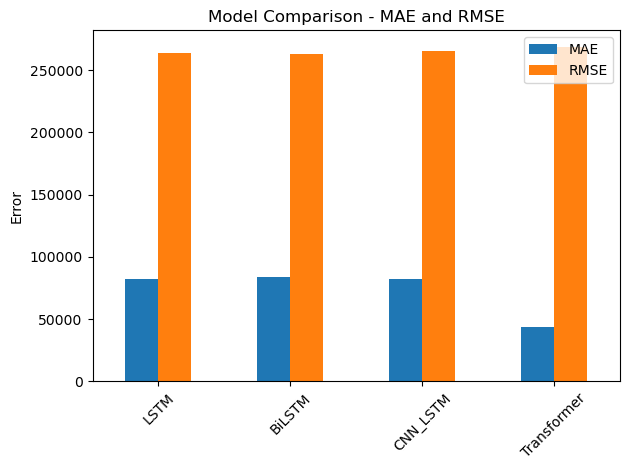

In [15]:
plt.figure(figsize=(10, 6))
results_df[['MAE', 'RMSE']].plot(kind='bar', rot=45)
plt.title('Model Comparison - MAE and RMSE')
plt.ylabel('Error')
plt.tight_layout()
plt.savefig(OUT_DIR / "model_comparison.png")
plt.show()

### Feature importance analysis (for best model)

In [16]:
best_model_name = results_df['MAE'].idxmin()
print(f"\nBest model: {best_model_name}")


Best model: Transformer


## Visualization

In [20]:
def plot_predictions(y_true, y_pred, model_name):
    """Create comprehensive prediction plots"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Scatter plot
    axes[0,0].scatter(y_true, y_pred, alpha=0.6)
    axes[0,0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    axes[0,0].set_xlabel('Actual')
    axes[0,0].set_ylabel('Predicted')
    axes[0,0].set_title(f'{model_name} - Actual vs Predicted')
    
    # Residual plot
    residuals = y_pred - y_true
    axes[0,1].scatter(y_pred, residuals, alpha=0.6)
    axes[0,1].axhline(y=0, color='r', linestyle='--')
    axes[0,1].set_xlabel('Predicted')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].set_title(f'{model_name} - Residual Plot')
    
    # Distribution plot
    axes[1,0].hist(residuals, bins=50, alpha=0.7)
    axes[1,0].axvline(x=0, color='r', linestyle='--')
    axes[1,0].set_xlabel('Residuals')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].set_title(f'{model_name} - Residual Distribution')
    
    # Error by magnitude
    error_by_magnitude = pd.DataFrame({
        'actual': y_true,
        'absolute_error': np.abs(residuals)
    })
    # Error by magnitude - Versión robusta
    error_by_magnitude = pd.DataFrame({
        'actual': y_true,
        'absolute_error': np.abs(residuals)
    })
    
    # Filtrar valores únicos para evitar el error
    unique_vals = error_by_magnitude['actual'].nunique()
    n_bins = min(10, unique_vals)  # No más bins que valores únicos
    
    if n_bins > 1:
        try:
            error_by_magnitude['magnitude_bin'] = pd.qcut(
                error_by_magnitude['actual'], 
                q=n_bins, 
                duplicates='drop'
            )
        except:
            error_by_magnitude['magnitude_bin'] = pd.cut(
                error_by_magnitude['actual'], 
                bins=n_bins
            )
        
        bin_errors = error_by_magnitude.groupby('magnitude_bin')['absolute_error'].mean()
        
        axes[1,1].bar(range(len(bin_errors)), bin_errors.values)
        axes[1,1].set_xlabel('Actual Value Bins')
        axes[1,1].set_ylabel('Mean Absolute Error')
        axes[1,1].set_title(f'{model_name} - Error by Magnitude')
        axes[1,1].set_xticks(range(len(bin_errors)))
        axes[1,1].set_xticklabels([str(bin) for bin in bin_errors.index], rotation=45)
    else:
        axes[1,1].text(0.5, 0.5, 'Insufficient unique values for binning', 
                      ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Error by Magnitude - Not Available')
    
    
    axes[1,1].bar(range(len(bin_errors)), bin_errors.values)
    axes[1,1].set_xlabel('Actual Value Bins')
    axes[1,1].set_ylabel('Mean Absolute Error')
    axes[1,1].set_title(f'{model_name} - Error by Magnitude')
    axes[1,1].set_xticks(range(len(bin_errors)))
    axes[1,1].set_xticklabels([f'Bin {i+1}' for i in range(len(bin_errors))], rotation=45)
    
    plt.tight_layout()
    plt.savefig(OUT_DIR / f"{model_name}_detailed_analysis.png")
    plt.show()

## Conclusion

In [18]:
best_model = models.load_model(OUT_DIR / f"{best_model_name}_model.keras")

/home/e.ladino/miniconda3/envs/e_ladino/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


/tmp/ipykernel_307570/530392836.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_errors = error_by_magnitude.groupby('magnitude_bin')['absolute_error'].mean()


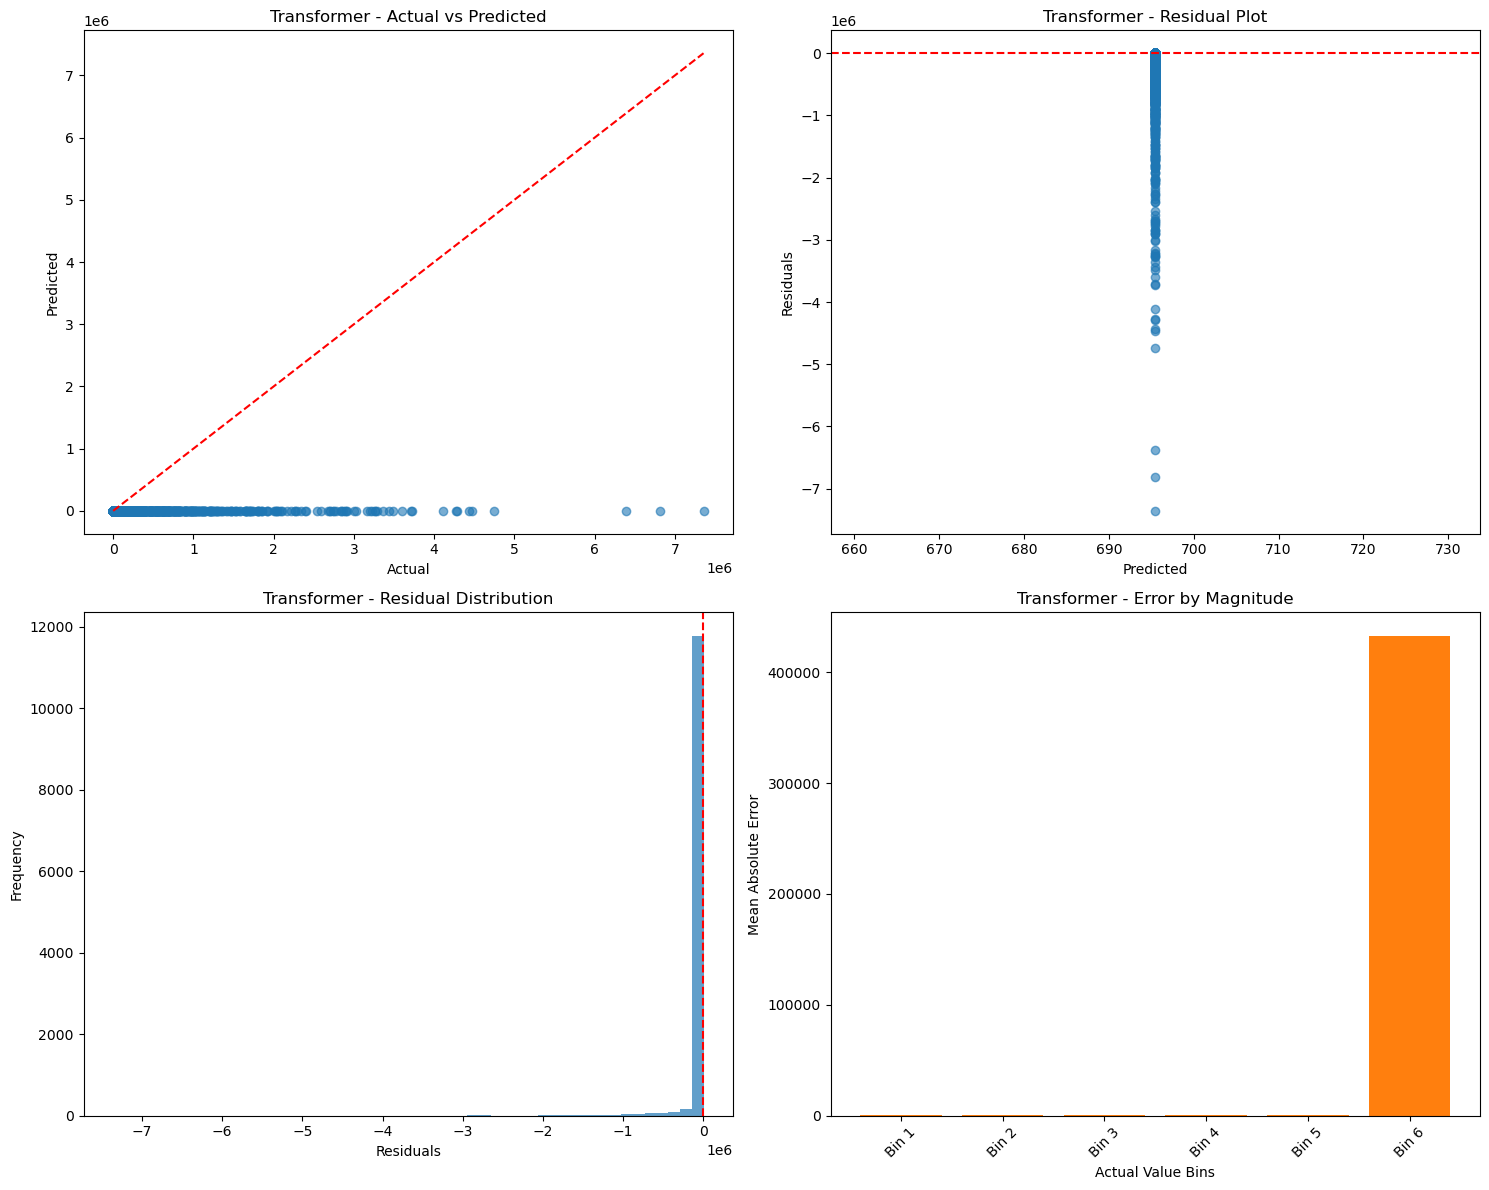


Best model (Transformer) detailed metrics:
MAE: 43401.1195
RMSE: 268619.7836
R2: -0.0252
MBE: -42154.7820


In [21]:
best_metrics, best_predictions = evaluate_model(best_model, X_test, y_test, f"best_{best_model_name}")
plot_predictions(y_test, best_predictions, best_model_name)

print(f"\nBest model ({best_model_name}) detailed metrics:")
for metric, value in best_metrics.items():
    print(f"{metric}: {value:.4f}")